# Artificial Intelligence
# 464/664
# Assignment #5

## General Directions for this Assignment

00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, 
02. Output format should be exactly as requested (it is your responsibility to make sure notebook looks as expected on Gradescope),
03. Each helper function should be preceeded by documentation (Markdown cell),
04. No comments in the code; anything worth mentioning should be included in the documentation,
05. Use descriptive variable names,
06. Functions should do only one thing,
07. Check submission deadline on Gradescope, 
08. Rename the file to Last_First_assignment_5, 
09. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
10. Do not submit any other files.

## Directions _not_ applicable for this Assignment:
* Do not use classes,
* Keep functions to 20 lines or less (including empty lines so do not add any),
* Each helper function should be followed by three assert-style unit tests.

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".

## Genetic Algorithms

Color Europe from Assignment #4 using four colors: ["red", "blue", "green", "yellow"]. 

Your implementation should:

* Start with a random population of candidates
* Run for a defined number of generations
* Select parents (implement both roulette and tournament, but use one)
* Apply Crossover
* Apply Mutation
* Apply Culling (remove a fraction of the lowest fitness individuals from the new population)

You'll need encoders/decoders to switch between genomes and phenomes. 

You'll need an approproate fitness function. 

You'll need a suite of tunable parameters (number of generations, crossover rate, location, mutation rate, location, value, culling rate, and so on).

Every ten generations, print out the generation number, the fitness, genotype, and phenotype of the best individual in the population for the specific generation. Return the best individual of the entire run (in the same format).

Feel free to port over helper functions from your solution to Assignment #4. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy
from collections import defaultdict
import numpy as np
import random

# declare graphs

In [3]:
connecticut_graph = { "nodes": ["Fairfield", "Litchfield", "New Haven", "Hartford", "Middlesex", "Tolland", "New London", "Windham"],
                "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)],
                "coordinates": [( 46, 52), ( 65,142), (104, 77), (123,142), (147, 85), (162,140), (197, 94), (217,146)]}

europe_graph = {
    "nodes":  ["Iceland", "Ireland", "United Kingdom", "Portugal", "Spain",
                 "France", "Belgium", "Netherlands", "Luxembourg", "Germany",
                 "Denmark", "Norway", "Sweden", "Finland", "Estonia",
                 "Latvia", "Lithuania", "Poland", "Czech Republic", "Austria",
                 "Liechtenstein", "Switzerland", "Italy", "Malta", "Greece",
                 "Albania", "Macedonia", "Kosovo", "Montenegro", "Bosnia Herzegovina",
                 "Serbia", "Croatia", "Slovenia", "Hungary", "Slovakia",
                 "Belarus", "Ukraine", "Moldova", "Romania", "Bulgaria",
                 "Cyprus", "Turkey", "Georgia", "Armenia", "Azerbaijan",
                 "Russia" ], 
    "edges": [(0,1), (0,2), (1,2), (2,5), (2,6), (2,7), (2,11), (3,4),
                 (4,5), (4,22), (5,6), (5,8), (5,9), (5,21), (5,22),(6,7),
                 (6,8), (6,9), (7,9), (8,9), (9,10), (9,12), (9,17), (9,18),
                 (9,19), (9,21), (10,11), (10,12), (10,17), (11,12), (11,13), (11,45), 
                 (12,13), (12,14), (12,15), (12,17), (13,14), (13,45), (14,15),
                 (14,45), (15,16), (15,35), (15,45), (16,17), (16,35), (17,18),
                 (17,34), (17,35), (17,36), (18,19), (18,34), (19,20), (19,21), 
                 (19,22), (19,32), (19,33), (19,34), (20,21), (21,22), (22,23),
                 (22,24), (22,25), (22,28), (22,29), (22,31), (22,32), (24,25),
                 (24,26), (24,39), (24,40), (24,41), (25,26), (25,27), (25,28),
                 (26,27), (26,30), (26,39), (27,28), (27,30), (28,29), (28,30),
                 (29,30), (29,31), (30,31), (30,33), (30,38), (30,39), (31,32),
                 (31,33), (32,33), (33,34), (33,36), (33,38), (34,36), (35,36),
                 (35,45), (36,37), (36,38), (36,45), (37,38), (38,39), (39,41),
                 (40,41), (41,42), (41,43), (41,44), (42,43), (42,44), (42,45),
                 (43,44), (44,45)],
    "coordinates": [( 18,147), ( 48, 83), ( 64, 90), ( 47, 28), ( 63, 34),
                   ( 78, 55), ( 82, 74), ( 84, 80), ( 82, 69), (100, 78),
                   ( 94, 97), (110,162), (116,144), (143,149), (140,111),
                   (137,102), (136, 95), (122, 78), (110, 67), (112, 60),
                   ( 98, 59), ( 93, 55), (102, 35), (108, 14), (130, 22),
                   (125, 32), (128, 37), (127, 40), (122, 42), (118, 47),
                   (127, 48), (116, 53), (111, 54), (122, 57), (124, 65),
                   (146, 87), (158, 65), (148, 57), (138, 54), (137, 41),
                   (160, 13), (168, 29), (189, 39), (194, 32), (202, 33),
                   (191,118)]}

## get_adj_list

Given a constraint graph, returns a 2D adjacency list of neighbors for each node

- constraint_graph Dict: is a dictionary with "nodes", "edges", and "coordinates" keys

### returns
- adj_list List[List[]]: 2D adjacency list of neighbors for each node

In [4]:
def get_adj_list(constraint_graph):
  adj_list = defaultdict(list)
  for a, b in constraint_graph["edges"]:
    adj_list[a].append(b)
    adj_list[b].append(a)
  return adj_list


## encoder

Turn the genome, which represents a coloring of regions, into the phenome: the pictoral representation fo the coloring, using pyplot. Go from constraint_graph to a dict of nodes to colors.


- title Str: title of the plot
- constraint_graph Dict: is a dictionary with "nodes", "edges", and "coordinates" keys
- size Tuple[int, int]: size of the plot
- solution List[str]: optional, the solution coloring to plot

### returns
- None


In [5]:
def encoder(title, constraint_graph, size, solution=None):
    def as_dictionary(a_list):
        dct = {}
        for i, e in enumerate(a_list):
            dct[i] = e
        return dct
    G = nx.Graph()
    labels = as_dictionary(constraint_graph["nodes"])
    pos = as_dictionary(constraint_graph["coordinates"])
    nodes = [n for n in range(0, len(constraint_graph["nodes"]))]
    if solution:
        colors = solution
    else:
        colors = ['blue' for c in range(0,len(constraint_graph["nodes"]))]
    G.add_nodes_from(nodes)
    G.add_edges_from(constraint_graph["edges"])
    plt.figure(figsize=size, dpi=100)
    plt.title(title)
    nx.draw(G, node_color = colors, with_labels = True, labels = labels, pos = pos)
    

## decoder

Turn the phenome, which is a pictoral representation of a coloring of regions, into the genome: the representation of the coloring as a list of colors.

- color_dict Dict[int, str]: a dictionary with node indices as keys and colors as values

### returns
- coloring List[str]: a list of colors, one for each node


In [1]:
def decoder(color_dict):
  return [color_dict[i] for i in range(len(color_dict))]


## random_coloring

Generate a random coloring for a given graph.

- constraint_graph Dict: is a dictionary with "nodes", "edges", and "coordinates" keys
- colors List[str]: a list of colors to choose from
- trace Bool: optional, whether to print the coloring

### returns
- coloring List[str]: a list of colors, one for each node

In [6]:
def random_coloring(constraint_graph, colors, trace=False):
  num_nodes = len(constraint_graph["nodes"])
  return [random.choice(colors) for i in range(num_nodes)]


## fitness

Calculate the fitness of a given coloring.

- coloring List[str]: a list of colors, one for each node
- adj_list List[List[]]: 2D adjacency list of neighbors for each node

### returns
- fitness Int: the fitness of the coloring


In [7]:
def fitness(coloring, adj_list):
  fitness = 0
  for a in adj_list:
    for b in adj_list[a]:
      if coloring[a] != coloring[b]:
        fitness += 1
  return fitness


## pick_parents_roulette

Pick two parents using roulette selection. This involves picking a node with probabilities weighted by their fitness.

- colorings List[List[str]]: a list of colorings, one for each node
- adj_list List[List[]]: 2D adjacency list of neighbors for each node
- fitness_preference_pow Float: the power to raise fitness to
- except_node Int: optional, the node to exclude from selection

### returns
- parents List[List[str]]: a list of two colorings, the parents

In [ ]:
def pick_parents_roulette(colorings, adj_list, fitness_preference_pow, except_node=None):
  total_fitness = sum(fitness(c, adj_list) ** fitness_preference_pow for c in colorings if c != except_node)
  probabilities = [fitness(c, adj_list) ** fitness_preference_pow / total_fitness if c != except_node else 0 for c in colorings]
  parents = np.random.choice(range(len(colorings)), size=2, replace=False, p=probabilities)
  return [colorings[i] for i in parents]


## pick_parents_tournament

Get 7 parents at random (or whatever the tournament size is), and pick the best two.

- colorings List[List[str]]: a list of colorings, one for each node
- adj_list List[List[]]: 2D adjacency list of neighbors for each node
- tournament_size Int: the number of parents to choose from

### returns
- parents List[List[str]]: a list of two colorings, the parents

In [ ]:
def pick_parents_tournament(colorings, adj_list, tournament_size):
  parents = list(np.random.choice(range(len(colorings)), size=tournament_size, replace=False))
  parents.sort(key=lambda c: fitness(colorings[c], adj_list), reverse=True)
  return [colorings[parents[0]], colorings[parents[1]]]


## crossover

Perform a crossover between two parents: picks a random index, and swaps the two parents at that index, creating two children.

- parent1 List[str]: the first parent
- parent2 List[str]: the second parent
- crossover_rate Float: the probability of a crossover

### returns
- children List[List[str]]: a list of two colorings, the children

In [ ]:
def crossover(parent1, parent2, crossover_rate):
  if random.random() > crossover_rate: return parent1, parent2
  crossover_point = random.randint(0, len(parent1))
  child_1 = parent1[:crossover_point] + parent2[crossover_point:]
  child_2 = parent2[:crossover_point] + parent1[crossover_point:]
  return child_1, child_2


## mutate

Mutate a coloring by randomly changing each node's color with a given probability.

- coloring List[str]: the coloring to mutate
- colors List[str]: a list of colors to choose from
- mutation_rate Float: the probability of a mutation

### returns
- mutated_coloring List[str]: the mutated coloring

In [ ]:
def mutate(coloring, colors, mutation_rate):
  return [random.choice(colors) if random.random() < mutation_rate else coloring[i] for i in range(len(coloring))]


## cull

Cull a fraction of the lowest fitness individuals from the population.

- colorings List[List[str]]: a list of colorings, one for each node
- adj_list List[List[]]: 2D adjacency list of neighbors for each node
- culling_rate Float: the fraction of the population to cull

### returns
- culled_colorings List[List[str]]: the culled colorings

In [ ]:
def cull(colorings, adj_list, culling_rate):
  colorings.sort(key=lambda c: fitness(c, adj_list), reverse=True)
  rem_size = int(len(colorings) * (1 - culling_rate))
  return colorings[:max(rem_size, 2)]


## run_ga

Run the genetic algorithm.

- graph Dict: is a dictionary with "nodes", "edges", and "coordinates" keys
- graph_dims Tuple[int, int]: the dimensions of the graph
- colors List[str]: a list of colors to choose from
- num_generations Int: the number of generations to run
- population_size Int: the size of the population
- crossover_rate Float: the probability of a crossover
- mutation_rate Float: the probability of a mutation
- culling_rate Float: the fraction of the population to cull
- fitness_preference_pow Float: the power to raise fitness to
- tournament_size Int: optional, the size of the tournament
- verbose Bool: optional, whether to print the fitness

### returns
- best_fitness Int: the best fitness of the population


In [19]:
def run_ga(graph, graph_dims, colors, num_generations, population_size, crossover_rate, mutation_rate, culling_rate, fitness_preference_pow, tournament_size, verbose=False):
  colorings = [random_coloring(graph, colors) for _ in range(population_size)]
  adj_list = get_adj_list(graph)
  max_fitness = sum(len(neighs) for neighs in adj_list.values())
  best_coloring = max(colorings, key=lambda c: fitness(c, adj_list))
  best_fitness = fitness(best_coloring, adj_list)
  best_gen = 0

  for gen in range(num_generations):
    # cull
    colorings = cull(colorings, adj_list, culling_rate)

    # crossover and mutate
    next_gen = []
    for i in range(population_size):
      parent_1, parent_2 = pick_parents_tournament(colorings, adj_list, tournament_size)
      child_1, child_2 = crossover(parent_1, parent_2, crossover_rate)
      child_1, child_2 = mutate(child_1, colors, mutation_rate), mutate(child_2, colors, mutation_rate)
      next_gen += [child_1, child_2]

      # keep track of best coloring
      for child in [child_1, child_2]:
        if fitness(child, adj_list) > best_fitness:
          best_coloring, best_fitness, best_gen = child, fitness(child, adj_list), gen
    colorings = next_gen

    # print fitness
    best_coloring = max(colorings, key=lambda c: fitness(c, adj_list))
    if gen % 10 == 0 and verbose:
      print(f'gen {gen}:')
      print(f'  best fitness: {best_fitness} / {max_fitness}')
      print('  best genotype:', best_coloring)
      encoder('Connecticut', graph, graph_dims, best_coloring)

  if verbose:
    encoder("Connecticut", graph, graph_dims, best_coloring)
    print('\nALL TIME:')
    print(f'  gen: {best_gen}')
    print(f'  fitness: {best_fitness} / {max_fitness}')
    print('  genotype:', best_coloring)
  return best_fitness



## run the genetic algorithm on europe_graph

gen 0:
  best fitness: 196 / 222
  best genotype: ['green', 'yellow', 'red', 'blue', 'green', 'green', 'blue', 'red', 'red', 'yellow', 'red', 'yellow', 'blue', 'red', 'yellow', 'green', 'red', 'green', 'blue', 'green', 'yellow', 'blue', 'yellow', 'blue', 'blue', 'red', 'red', 'blue', 'yellow', 'green', 'red', 'blue', 'yellow', 'green', 'yellow', 'green', 'blue', 'red', 'yellow', 'blue', 'red', 'green', 'green', 'red', 'red', 'blue']
gen 10:
  best fitness: 212 / 222
  best genotype: ['red', 'blue', 'yellow', 'yellow', 'blue', 'green', 'red', 'blue', 'yellow', 'yellow', 'blue', 'red', 'green', 'blue', 'red', 'blue', 'green', 'red', 'blue', 'red', 'yellow', 'blue', 'yellow', 'red', 'red', 'blue', 'yellow', 'green', 'red', 'green', 'blue', 'red', 'green', 'green', 'yellow', 'red', 'blue', 'green', 'red', 'yellow', 'blue', 'green', 'red', 'green', 'yellow', 'green']
gen 20:
  best fitness: 218 / 222
  best genotype: ['green', 'blue', 'yellow', 'yellow', 'red', 'green', 'red', 'blue', 'blue

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



ALL TIME:
  gen: 29
  fitness: 222 / 222
  genotype: ['blue', 'red', 'yellow', 'yellow', 'blue', 'green', 'red', 'blue', 'blue', 'yellow', 'blue', 'red', 'green', 'blue', 'red', 'blue', 'yellow', 'red', 'blue', 'red', 'yellow', 'blue', 'yellow', 'green', 'red', 'blue', 'yellow', 'green', 'red', 'green', 'blue', 'red', 'blue', 'green', 'yellow', 'green', 'blue', 'red', 'yellow', 'green', 'green', 'blue', 'green', 'yellow', 'red', 'yellow']


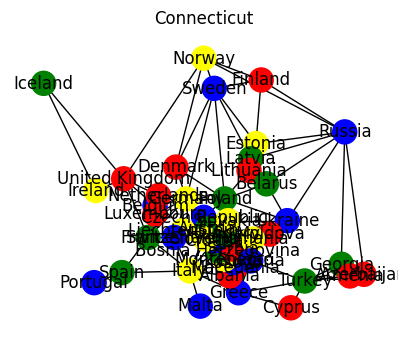

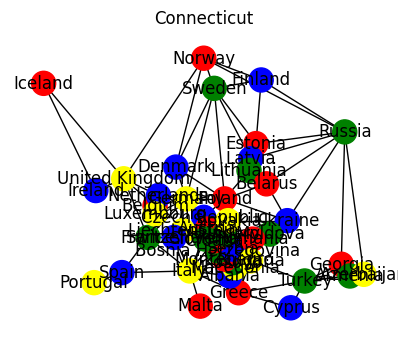

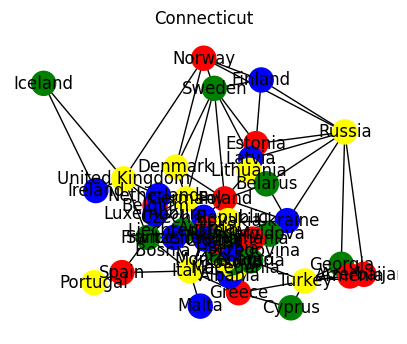

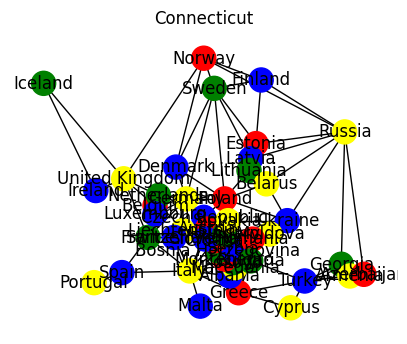

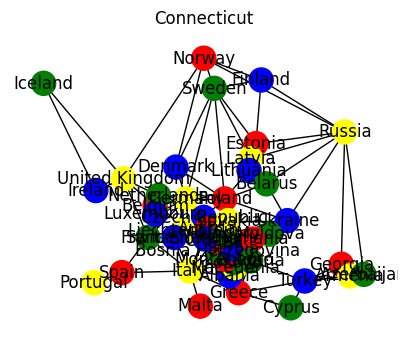

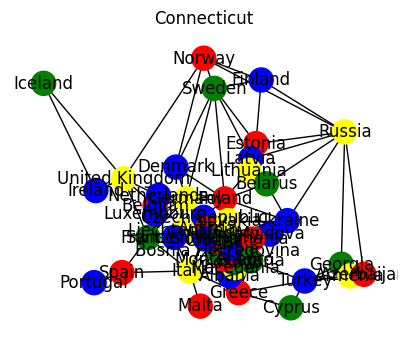

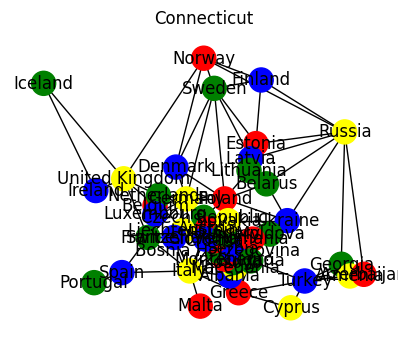

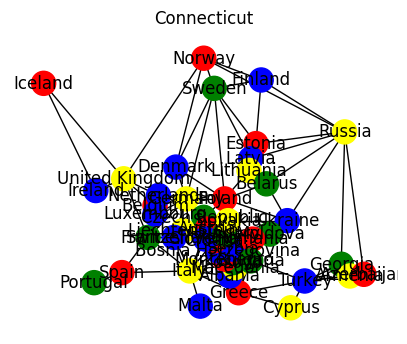

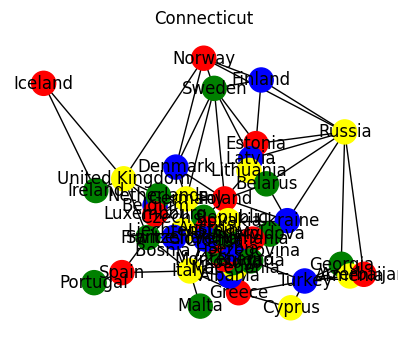

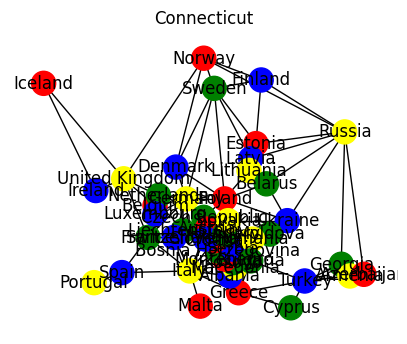

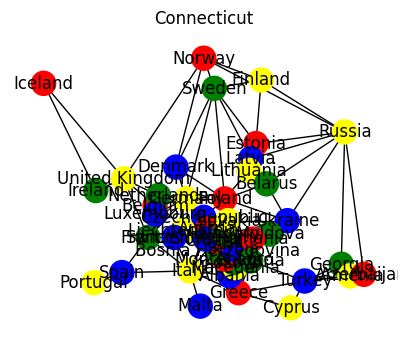

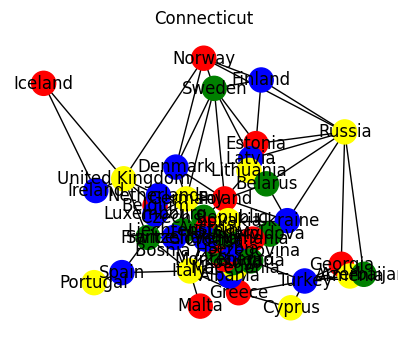

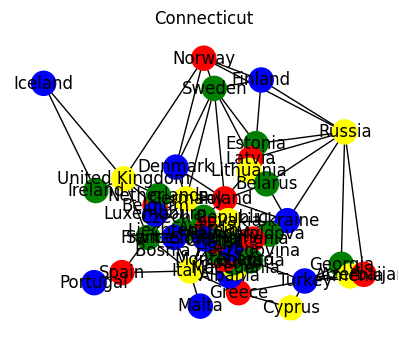

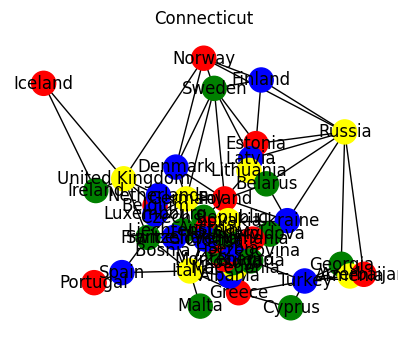

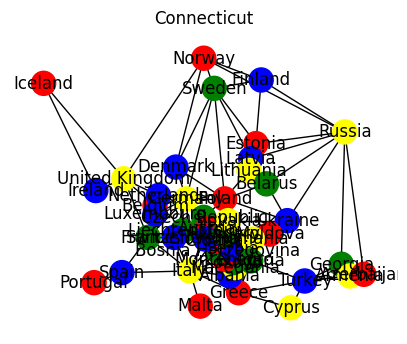

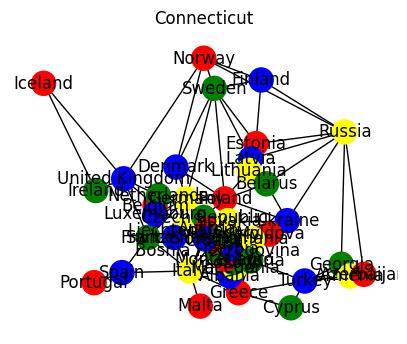

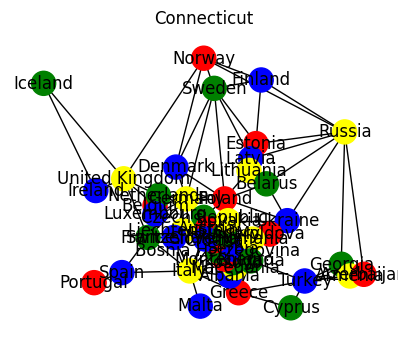

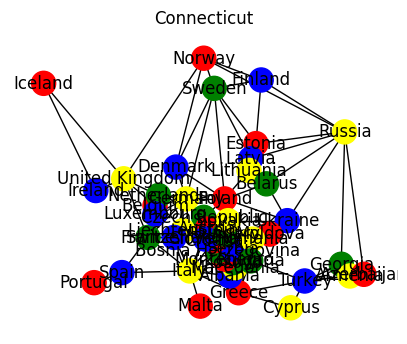

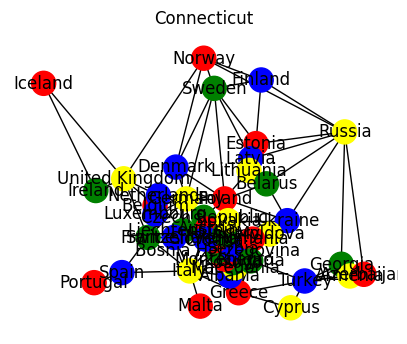

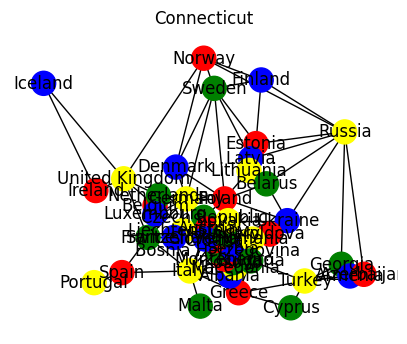

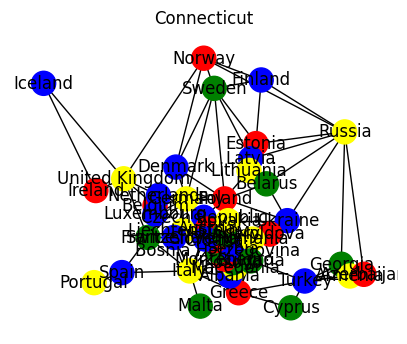

In [22]:
_ = run_ga(
  europe_graph, 
  (5,4), 
  ["red", "blue", "green", "yellow"],
  num_generations=200,
  population_size=200,
  crossover_rate=.8,
  mutation_rate=0.1,
  culling_rate=0.8,
  fitness_preference_pow=1,
  tournament_size=5,
  verbose=True,
)

## OPTIONAL. BONUS.

Explore different settings for your parameter values and produce plots revealing the performance of your algorithm against the parameters.

## graph num_generations vs fitness

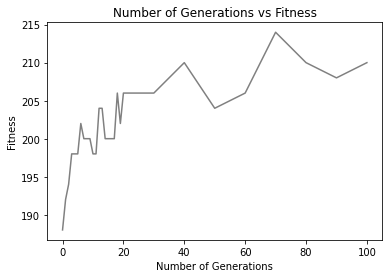

In [11]:
generations = [i for i in range(20)] + [i * 10 for i in range(2, 11)]  # X-coordinates of dots
y = [
  run_ga(
  europe_graph,
  (5,4),
  ["red", "blue", "green", "yellow"],
  num_generations=g,
  population_size=50,
  crossover_rate=.8,
  mutation_rate=0.1,
  culling_rate=0.2,
  fitness_preference_pow=1,
  tournament_size=5,
  verbose=False,
  ) for g in generations
]

# Creating the scatter plot
# plt.scatter(x, y, alpha=0.7)
plt.plot(generations, y, linestyle='-', color='gray')
plt.xlabel("Number of Generations")
plt.ylabel("Fitness")
plt.title("Number of Generations vs Fitness")
plt.show()

## graph population size vs fitness

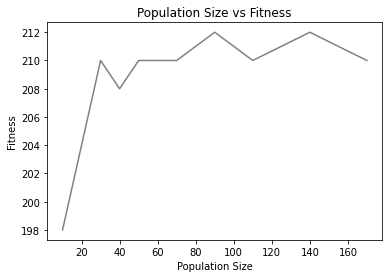

In [17]:
population_size = [10, 20, 30, 40, 50, 70, 90, 110, 140, 170]  # X-coordinates of dots
y = [
  run_ga(
  europe_graph,
  (5,4),
  ["red", "blue", "green", "yellow"],
  num_generations=100,
  population_size=p,
  crossover_rate=.8,
  mutation_rate=0.1,
  culling_rate=0.2,
  fitness_preference_pow=1,
  tournament_size=min(5, p // 5),
  verbose=False,
  ) for p in population_size
]

# Creating the scatter plot
# plt.scatter(x, y, alpha=0.7)
plt.plot(population_size, y, linestyle='-', color='gray')
plt.xlabel("Population Size")
plt.ylabel("Fitness")
plt.title("Population Size vs Fitness")
plt.show()

## graph num_generations and population_size, where you have fixed area of num_generations * population_size
- Simulate some constant computing constraints — should you allocate more towards generations or towards population size?


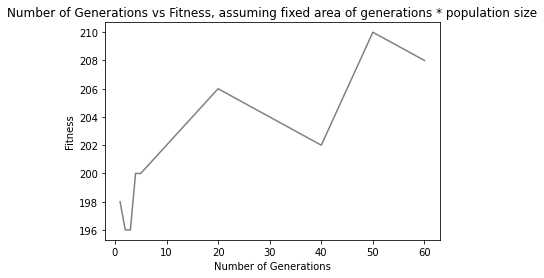

In [13]:
fixed_area = 1000
num_generations = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]
fitness_data = [
  run_ga(
    europe_graph,
    (5,4),
    ["red", "blue", "green", "yellow"],
    num_generations=g,
    population_size=fixed_area // g,
    crossover_rate=.8,
    mutation_rate=0.1,
    culling_rate=0.2,
    fitness_preference_pow=1,
    tournament_size=5,
    verbose=False,
  )
  for g in num_generations
]

plt.plot(num_generations, fitness_data, linestyle='-', color='gray')
plt.xlabel("Number of Generations")
plt.ylabel(f"Fitness")
plt.title("Number of Generations vs Fitness, assuming fixed area of generations * population size")
plt.show()

## graph crossover_rate vs fitness

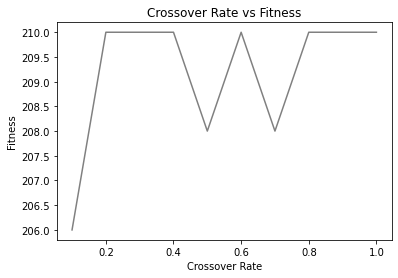

In [14]:
crossover_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fitness_data = [
  run_ga(
    europe_graph,
    (5,4),
    ["red", "blue", "green", "yellow"],
    num_generations=100,
    population_size=50,
    crossover_rate=c,
    mutation_rate=0.1,
    culling_rate=0.2,
    fitness_preference_pow=1,
    tournament_size=5,
    verbose=False,
  ) 
  for c in crossover_rate
]

plt.plot(crossover_rate, fitness_data, linestyle='-', color='gray')
plt.xlabel("Crossover Rate")
plt.ylabel(f"Fitness")
plt.title("Crossover Rate vs Fitness")
plt.show()

## graph mutation_rate vs fitness

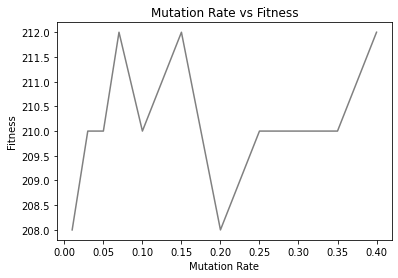

In [15]:
mutation_rate = [0.01, .03, .05, .07, .1, .15, .2, .25, .3, .35, .4]
fitness_data = [
  run_ga(
    europe_graph,
    (5,4),
    ["red", "blue", "green", "yellow"],
    num_generations=100,
    population_size=50,
    crossover_rate=0.8,
    mutation_rate=.1,
    culling_rate=0.2,
    fitness_preference_pow=1,
    tournament_size=5,
    verbose=False,
  ) 
  for m in mutation_rate
]

plt.plot(mutation_rate, fitness_data, linestyle='-', color='gray')
plt.xlabel("Mutation Rate")
plt.ylabel(f"Fitness")
plt.title("Mutation Rate vs Fitness")
plt.show()

## graph culling_rate vs fitness

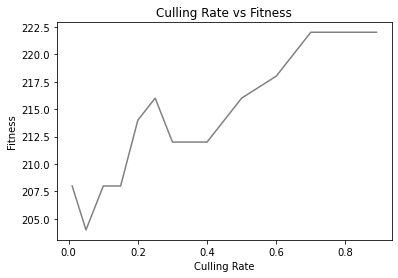

In [16]:
culling_rate = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.89]
fitness_data = [
  run_ga(
    europe_graph,
    (5,4),
    ["red", "blue", "green", "yellow"],
    num_generations=100,
    population_size=50,
    crossover_rate=0.8,
    mutation_rate=0.1,
    culling_rate=c,
    fitness_preference_pow=1,
    tournament_size=5,
    verbose=False,
  ) 
  for c in culling_rate
]

plt.plot(culling_rate, fitness_data, linestyle='-', color='gray')
plt.xlabel("Culling Rate")
plt.ylabel(f"Fitness")
plt.title("Culling Rate vs Fitness")
plt.show()

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".